In [18]:
# This script takes the bricked, resampled output of 6_PET.R and resamples it temporally to aggregate to necessary timesteps. 
# Anna Boser Nov 5, 2021

from pyprojroot import here
import rasterio
import datetime
import numpy as np
import pandas as pd
import pickle
from osgeo import gdal, gdalconst
import matplotlib.pyplot as plt

In [2]:
img = rasterio.open(here("./data/intermediate/PET/PETbrick_OGres.tif")) # NA values are -3.4e+38
array = np.array(img.read())

# get a list of the start indices and end indices of each of your time intervals

# these are the dates of the images (bands) in order
base = datetime.date(day = 1, month = 1, year = 2019) # start Jan 1 2019
date_list = [base + datetime.timedelta(days=x) for x in range(img.count)]

In [3]:
# the time intervals I want go back in time to previous years so I need to reshuffle the datasets a bit into their respective years and put jan1-14 at the end
# first break up by year

imgs_2019 = array[[d.year==2019 for d in date_list]]
imgs_2020 = array[[d.year==2020 for d in date_list]]

date_array = np.array(date_list)
dates_2019 = date_array[[d.year==2019 for d in date_list]]
dates_2020 = date_array[[d.year==2020 for d in date_list]]

# move anything from January 1 to 14 to after
# imgs_2019 = np.concatenate([imgs_2019[14:], imgs_2019[:14]])
# imgs_2020 = np.concatenate([imgs_2020[14:], imgs_2020[:14]])

imgs_2019 = np.concatenate([imgs_2019[[d >= datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]], imgs_2019[[d < datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]]])
imgs_2020 = np.concatenate([imgs_2020[[d >= datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]], imgs_2020[[d < datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]]])

dates_2019 = np.concatenate([dates_2019[[d >= datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]], dates_2019[[d < datetime.date(day = 15, month = 1, year = 2019) for d in dates_2019]]])
dates_2020 = np.concatenate([dates_2020[[d >= datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]], dates_2020[[d < datetime.date(day = 15, month = 1, year = 2020) for d in dates_2020]]])



In [5]:
# I am going to mess up the dates for convenience by shifting the beginning of 2019 to be the beginning of 2020 and the beginning of 2020 to be the biginning of 2021 
# just for convenience
array = np.concatenate([imgs_2019, imgs_2020])

base = datetime.date(day = 15, month = 1, year = 2019)
fakedates = [base + datetime.timedelta(days=x) for x in range(img.count)]

In [12]:
# these are the start dates of the wanted time intervals
date_starts = [datetime.date(day = 15, month = m, year = y) for y in range(2019,2021) for m in [1,3,5,7,9,11]]
del date_starts[1]

In [13]:
date_starts

[datetime.date(2019, 1, 15),
 datetime.date(2019, 5, 15),
 datetime.date(2019, 7, 15),
 datetime.date(2019, 9, 15),
 datetime.date(2019, 11, 15),
 datetime.date(2020, 1, 15),
 datetime.date(2020, 3, 15),
 datetime.date(2020, 5, 15),
 datetime.date(2020, 7, 15),
 datetime.date(2020, 9, 15),
 datetime.date(2020, 11, 15)]

In [14]:
# write date_starts so that we have a metadata record of dates
with open(here("./data/intermediate/start_dates_yeargrouped.pkl"), 'wb') as f:
    pickle.dump(date_starts, f)

In [16]:
# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first one not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)

metadata = img.profile
metadata['count'] = 11

# write your new raster
with rasterio.open(here("./data/intermediate/PET/PET_yeargrouped_avg_OGres.tif"), 'w', **metadata) as dst:
    dst.write(newarray)
    

In [20]:
# now use resample this array to the CA_grid resolution. See https://stackoverflow.com/questions/10454316/how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python

# Source
src_filename = str(here("./data/intermediate/PET/PET_yeargrouped_avg_OGres.tif"))
src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()

# We want a section of source that matches this:
match_filename = str(here("./data/intermediate/CA_grid.tif"))
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

# Output / destination
dst_filename = str(here("./data/intermediate/PET/PET_yeargrouped_avg.tif"))
dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 11, gdalconst.GDT_Float32)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

del dst # Flush

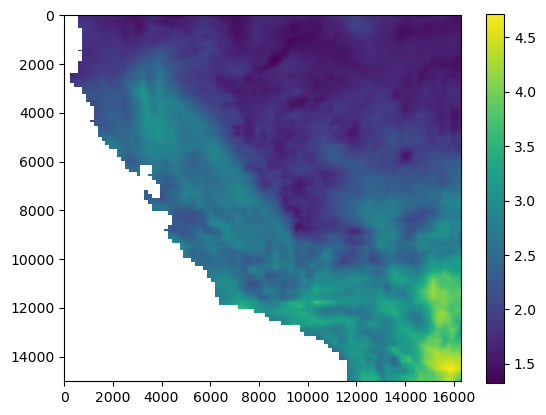

In [30]:
src1_filename = str(here("./data/intermediate/PET/PET_yeargrouped_avg.tif"))
src1 = gdal.Open(src1_filename, gdalconst.GA_ReadOnly)
ar = src1.ReadAsArray()

plt.figure()
plt.imshow(ar[3,:,:])
plt.colorbar()
plt.show() # this looks ok though I'm not sure why it looks so smoothed and why it didn't get a bunch of pixels on the border

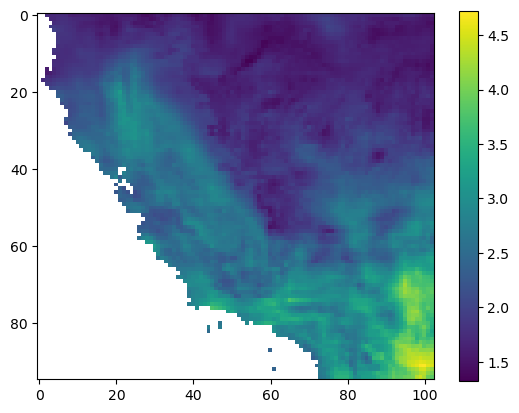

In [31]:
ar1 = src.ReadAsArray()

plt.figure()
plt.imshow(ar1[3,:,:])
plt.colorbar()
plt.show()